<div style="text-align:right">
    <b>Author:</b> Andreas P. Koenzen (akc at apkc.net) / <a href="http://www.apkc.net">www.apkc.net</a>
</div>

# Mosaic

## Imports

In [34]:
%run '../../../imports.py'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

All modules have been imported correctly.



<Figure size 530x400 with 0 Axes>

## Configuration

In [14]:
%run '../../../config.py'

## Environment variables

In [15]:
%run '../../../env_variables.py'

## Do something!

W:479 H:406 AR:1.1798029556650247


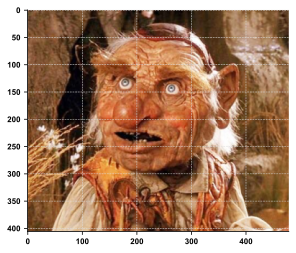

In [17]:
with Image.open("/Users/akc/Downloads/Img/0004.jpg") as im:
    _ = plt.imshow(im)
    print(f"W:{im.size[0]} H:{im.size[1]} AR:{im.size[0]/im.size[1]}")

In [35]:
from pydantic import BaseModel
class TemporaryPhoto(BaseModel):
    width: int  # Mandatory
    height: int  # Mandatory
    aspect_ratio: float  # Mandatory
    distance: float = None  # Optional

    class Config:
        orm_mode = False

In [36]:
from typing import Dict
# Grab all the photos, sort them by width. We
# want the bigger images more than the small
# ones.
photos: Dict = {}
for file in glob.glob("/Users/akc/Downloads/Img/*.jpg"):
    with Image.open(file) as im:
        w = im.size[0]
        h = im.size[1]
        if w is not None and h is not None:
            if w > 0 and h > 0:
                photos[file] = TemporaryPhoto(
                    width=w,
                    height=h,
                    aspect_ratio=im.size[0] / im.size[1],
                )
photos = dict(
    sorted(
        photos.items(),
        key=lambda k: k[1].width,
        reverse=True,
    ),
)
photos

{'/Users/akc/Downloads/Img/0009.jpg': TemporaryPhoto(width=1000, height=1500, aspect_ratio=0.6666666666666666, distance=None),
 '/Users/akc/Downloads/Img/0005.jpg': TemporaryPhoto(width=800, height=530, aspect_ratio=1.509433962264151, distance=None),
 '/Users/akc/Downloads/Img/0003.jpg': TemporaryPhoto(width=640, height=800, aspect_ratio=0.8, distance=None),
 '/Users/akc/Downloads/Img/0010.jpg': TemporaryPhoto(width=636, height=936, aspect_ratio=0.6794871794871795, distance=None),
 '/Users/akc/Downloads/Img/0006.jpg': TemporaryPhoto(width=600, height=314, aspect_ratio=1.910828025477707, distance=None),
 '/Users/akc/Downloads/Img/0007.jpg': TemporaryPhoto(width=590, height=845, aspect_ratio=0.6982248520710059, distance=None),
 '/Users/akc/Downloads/Img/0012.jpg': TemporaryPhoto(width=583, height=864, aspect_ratio=0.6747685185185185, distance=None),
 '/Users/akc/Downloads/Img/0008.jpg': TemporaryPhoto(width=568, height=724, aspect_ratio=0.7845303867403315, distance=None),
 '/Users/akc/Do

In [38]:
#
# Keep the top 2 that closely matches the ratio
# 1.91 and 1 that matches the ratio .96.
#
# Keep all within .5 of distance.
#
to_process_1: Dict = {}
to_process_2_3: Dict = {}
if len(photos) >= 3:
    for name, photo in photos.items():
        distance_1 = abs(photo.aspect_ratio - 1.91)
        distance_2 = abs(photo.aspect_ratio - 0.96)
        if distance_1 <= 0.5:
            photo.distance = distance_1
            to_process_2_3[name] = photo
        if distance_2 <= 0.5:
            photo.distance = distance_2
            to_process_1[name] = photo
to_process_1 = dict(
    sorted(
        to_process_1.items(),
        key=lambda k: k[1].distance,
        reverse=False,
    ),
)
to_process_2_3 = dict(
    sorted(
        to_process_2_3.items(),
        key=lambda k: k[1].distance,
        reverse=False,
    ),
)
if len(to_process_1) >= 1:
    to_process_1 = dict(itertools.islice(to_process_1.items(), 1))
if len(to_process_2_3) >= 2:
    to_process_2_3 = dict(itertools.islice(to_process_2_3.items(), 2))

print(to_process_1)
print("===")
print(to_process_2_3)

{'/Users/akc/Downloads/Img/0002.jpg': TemporaryPhoto(width=315, height=340, aspect_ratio=0.9264705882352942, distance=0.03352941176470581)}
===
{'/Users/akc/Downloads/Img/0006.jpg': TemporaryPhoto(width=600, height=314, aspect_ratio=1.910828025477707, distance=0.0008280254777071061), '/Users/akc/Downloads/Img/0013.jpg': TemporaryPhoto(width=480, height=270, aspect_ratio=1.7777777777777777, distance=0.13222222222222224)}


W:1200 H:630 AR:1.9047619047619047


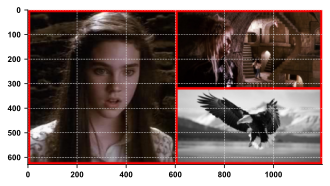

In [66]:
outcome_image = TemporaryPhoto(width=1200, height=630, aspect_ratio=1.91)
#
# |------------------------------|
# | Box 1         | Box 2        |
# |               ---------------|
# |               | Box 3        |
# |------------------------------|
#
box_1 = TemporaryPhoto(width=600, height=630, aspect_ratio=0.96)
box_2_3 = TemporaryPhoto(width=600, height=315, aspect_ratio=1.91)
        
output: Image = Image.new(
    mode="RGB",
    size=(
        outcome_image.width,
        outcome_image.height,
    ),
    color="red",
)

for file in to_process_1:
    with Image.open(file) as tmp_image:
        with ImageOps.exif_transpose(tmp_image) as resized_image:
            border = 10
            
            box_w = 600
            box_h = 630

            src_w = resized_image.size[0]
            src_h = resized_image.size[1]

            crop_w = 0
            crop_h = 0
            # If the height of the source image is
            # bigger than the box height, then create a
            # thumbnail image and then extend.
            if src_h > box_h:
                resized_image.thumbnail(
                    size=(box_w - border, box_h - (border * 2)),
                    resample=Image.ANTIALIAS,
                )
            
            resized_image = resized_image.transform(
                (box_w - border, box_h - (border * 2)),
                Image.Transform.EXTENT,
                (0, 0, src_w, src_h),
                Image.Resampling.BILINEAR,
            )
            output.paste(resized_image, (0 + border, 0 + border))
for idx, file in enumerate(to_process_2_3):
    with Image.open(file) as tmp_image:
        with ImageOps.exif_transpose(tmp_image) as resized_image:
            border = 10
            
            box_w = 600
            box_h = 315

            src_w = resized_image.size[0]
            src_h = resized_image.size[1]

            crop_w = 0
            crop_h = 0
            # If the height of the source image is
            # bigger than the box height, then create a
            # thumbnail image and then extend.
            if src_w > box_w:
                resized_image.thumbnail(
                    size=(box_w - (border * 2), box_h - (border * 2)),
                    resample=Image.ANTIALIAS,
                )
            
            resized_image = resized_image.transform(
                (box_w - border * 2, box_h - (border * (idx + 1))),
                Image.Transform.EXTENT,
                (0, 0, src_w, src_h),
                Image.Resampling.BILINEAR,
            )
            output.paste(resized_image, (600 + border, 0 + border + (idx * 315)))

_ = plt.imshow(output)
print(f"W:{output.size[0]} H:{output.size[1]} AR:{output.size[0]/output.size[1]}")

***
# End